In [9]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import seaborn as sns
    
sns.set_style("darkgrid", {'xtick.top': True, 'ytick.right': True,'xtick.bottom': True, 'ytick.left': True,'grid.linestyle': '--','image.cmap': 'viridis','xtick.direction': 'in', 'ytick.direction': 'in'})

# @working path
FIG_PATH     = '../tex/figs/'
WEB_FIG_PATH = '../tex/web-figs/'
DATA_PATH    = '../code/'


# @global settings

FIG_DPI      = 800
FIG_EXT      = '.pdf'

# @global functions
def savefig(handler,name, fig_ext = FIG_EXT):
    if name != '':
        handler.savefig(FIG_PATH + name + fig_ext, dpi = FIG_DPI,bbox_inches = 'tight', pad_inches = 0.1)

Populating the interactive namespace from numpy and matplotlib


/home/yihan/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['savefig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:

PC     = 648000/np.pi
KPC    = 1000*PC 
AU     = 1
MS     = 1
YR     = 2 * np.pi
Hubble_t = 13.4e9*YR
V_UNIT = 2.9784651272402163E1
KMS    = 1.0/V_UNIT
lc     = 299792.458/V_UNIT
DAY    = YR/365.25636042
HR     = DAY/24
G= 1

In [11]:
def load_orbit(data,orbit_name):
    name = ['m1', 'm2', 'e', 'p', 'i', 'Omega', 'omega', 'nv']
    orbit={}
    for key, i in zip(name, range(len(name))):
        orbit.update({orbit_name+key : data[:,i]})
    return orbit

def load_incid_args(data):
    return {'v_inf': data[:,0], 'b':data[:,1], 'w':data[:,2], 'ii':data[:,3],'iphi':data[:,4]}

def load_post_scattered(data, obj_name):
    dic = {'time':data[:,0]}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 10*idx
        dic.update({'m_{' + name + '}': data[:,offset + 3],
                    'r_{' + name + '}': data[:,offset + 4],
                    'px_{' + name + '}': data[:,offset + 5],
                    'py_{' + name + '}': data[:,offset + 7],
                    'pz_{' + name + '}': data[:,offset + 7],
                    'vx_{' + name + '}': data[:,offset + 8],
                    'vy_{' + name + '}': data[:,offset + 9],
                    'vz_{' + name + '}': data[:,offset + 10]
                   })
    return dic
        
def load_closest(data, obj_name):
    dic ={}
    for name, idx in zip(obj_name, range(len(obj_name))):
        offset = 6*idx
        dic.update({'closest:px_{' + name + '}': data[:,offset + 0],
                    'closest:py_{' + name + '}': data[:,offset + 1],
                    'closest:pz_{' + name + '}': data[:,offset + 2],
                    'closest:vx_{' + name + '}': data[:,offset + 3],
                    'closest:vy_{' + name + '}': data[:,offset + 4],
                    'closest:vz_{' + name + '}': data[:,offset + 5]})
    return dic
        
def load_data(fname, os, objname):
    data = np.loadtxt(fname)
    
    dic = {}
    dic.update(load_orbit(data[:,os['sj-orbit-s']:os['sj-orbit-e']],'sj-orbit-') )
    dic.update(load_incid_args(data[:,os['incident-s']:os['incident-e']]))
    
    dic.update(load_post_scattered(data[:,os['post-s']:os['post-e']], objname))
    
    if 'closest-s' and 'closest-e' in os:
        dic.update(load_closest(data[:,os['closest-s']:os['closest-e']], objname))
    
    if 'sn-orbit-s' and 'sn-orbit-e' in os:
        dic.update(load_orbit(data[:,os['sn-orbit-s']:os['sn-orbit-e']],'sn-orbit-'))
        
    if 'ss-orbit-s' and 'ss-orbit-e' in os:
        dic.update(load_orbit(data[:,os['ss-orbit-s']:os['ss-orbit-e']],'ss-orbit-'))
        
    return dic

def get_a_e(m, drx, dry, drz, dvx, dvy, dvz):
    r  = np.sqrt(drx**2 + dry**2 + drz**2)
    v2 = dvx**2 + dvy**2 + dvz**2
    v  = np.sqrt(v2)
    
    vrdot = drx*dvx + dry*dvy + drz*dvz
    
    vdfsq = (v2 - m / r)
    ex = (vdfsq * drx - vrdot * dvx)
    ey = (vdfsq * dry - vrdot * dvy) 
    ez = (vdfsq * drz - vrdot * dvz) 
    e  = np.sqrt(ex * ex + ey * ey + ez * ez) / m
    a  = -m / (v2 - 2 * m/r)
    return a, e


def calc_pair_a_e(data, pairs):
    dic = {}
    for name_i, name_j in pairs:
        mi = data['m_{' + name_i + '}']
        mj = data['m_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        dvx = data['vx_{' + name_i + '}'] - data['vx_{' + name_j + '}']
        dvy = data['vy_{' + name_i + '}'] - data['vy_{' + name_j + '}']
        dvz = data['vz_{' + name_i + '}'] - data['vz_{' + name_j + '}']
        

        a, e = get_a_e(mi + mj, dpx, dpy, dpz, dvx, dvy, dvz)
        dic.update({'a_{' + name_i + ',' + name_j + '}': a,  'e_{' + name_i + ',' + name_j + '}': e})
    return dic
        
def calc_tidal_t_scale(data, star_name, planet_name='j'):
    mp = data['m_{'+planet_name+ '}']
    rp = data['r_{'+planet_name+ '}']
    dic = {}
    for name in star_name:
        rs = data['r_{' + name + '}']
        ms = data['m_{' + name + '}']
        #s = 9.0/4/2e7*mp/ms*rs**5
        p = 9.0/4/2.5e4*ms/mp*rp**5
        a = data['a_{' + name + ',' + planet_name + '}']
        e = data['e_{' + name + ',' + planet_name + '}']
        n = np.sqrt( G*(ms+mp)/a**3)
        tau_ap = 3/n*a**5/14/e**2/p
        dic.update({'T_{' + name + ',' + planet_name + '}' : tau_ap})
    return dic

def check_collision(data, pairs):
    dic ={}
    for name_i, name_j in pairs:
        ri = data['r_{' + name_i + '}']
        rj = data['r_{' + name_j + '}']
        
        dpx = data['px_{' + name_i + '}'] - data['px_{' + name_j + '}']
        dpy = data['py_{' + name_i + '}'] - data['py_{' + name_j + '}']
        dpz = data['pz_{' + name_i + '}'] - data['pz_{' + name_j + '}']
        
        
        coll = (dpx**2 + dpy**2 + dpz**2) <= (ri + rj)**2
        
        
        data['star outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        data['planet outcome'][coll] = 'coll_{' + name_i + ',' + name_j + '}'
        #dic.update({'coll_{' + name_i + ',' + name_j + '}': coll})
    #return dic

def classify_star_outcome(data, star_pairs):
    init_bound = np.ones(data['time'].shape, dtype=bool)
    init_unbound =np.ones(data['time'].shape, dtype=bool)
    disrupted = np.zeros(data['time'].shape, dtype=bool)
    
    for name_i, name_j in star_pairs:
        if (name_i == 's1') and (name_j == 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            init_bound = init_bound & bound
            init_unbound=init_unbound&unbound
            disrupted = np.ones(data['time'].shape, dtype=bool)
    
    
    flyby = np.ones(data['time'].shape, dtype=bool)
    
    bi_formation ={}
    for name_i, name_j in star_pairs:
        if (name_i != 's1') or (name_j != 's2'):
            a = data['a_{' + name_i + ',' + name_j + '}']
            e = data['e_{' + name_i + ',' + name_j + '}']
        
            bound = (a > 0) & (0 <=e) & (e < 1)
            unbound = (e >= 1) & (a <= 0) 
            
            bi_formation.update({'reunion_{' + name_i + ',' + name_j + '}': bound & init_unbound})
        
            flyby = flyby & unbound & init_bound
            
            disrupted = disrupted & unbound & init_unbound
        
    reunion = np.zeros(data['time'].shape, dtype=bool)
    for key, r in bi_formation.items():
        reunion = reunion | r
        
    data['star outcome'][reunion] = 'reunion'
    data['star outcome'][flyby]  = 'flyby'
    data['star outcome'][disrupted] = 'disrupted'
    
    #dic = {'reunion':reunion, 'flyby' : flyby, 'disrupted': disrupted}
    
    #dic.update(bi_formation)
            
    #return dic

def classify_planet_outcome(data, star_names, planet_name='j', a_final=0.1*AU):
    binary = []
    for star_name in star_names:
        a = data['a_{' + star_name + ',' + planet_name + '}']
        e = data['e_{' + star_name + ',' + planet_name + '}']
        tau_ap = data['T_{' + star_name + ',' + planet_name + '}']
        
        bound = (a > 0) & (0 <=e) & (e < 1)
        unbound = (e >= 1) & (a <= 0) 
        hot_jupiter_candi = (a*(1-e*e) < a_final) & (tau_ap < Hubble_t) 
        binary.append((star_name, bound, unbound, hot_jupiter_candi))
        
    dic={}
    for star_name1, bound1, unbound1, hj1 in binary:
        bound = bound1
        hot_jupiter = hj1
        for star_name2, bound2, unbound2, hj2 in binary:
            if(star_name1 != star_name2):
                bound = bound & unbound2
                hot_jupiter = hot_jupiter & unbound2
                
        data['planet outcome'][bound] = 'stay_{' + star_name1 + ',' + planet_name + '}'
        data['planet outcome'][hot_jupiter] = 'HJ_{' + star_name1 + ',' + planet_name + '}' 
    
        #dic.update({'stay_{' + star_name1 + ',' + planet_name + '}' : bound, 'HJ_{' + star_name1 + ',' + planet_name + '}' : hot_jupiter})
        
    ejection = np.ones(data['time'].shape, dtype=bool)
    for star_name, bound, unbound, hj in binary:
        ejection = ejection & unbound
        
        
    data['planet outcome'][ejection] = 'ejection_{'+planet_name+'}'
    
    #dic.update({'ejection_{'+planet_name+'}':ejection})

    #return dic
    
def post_process(fname, os, objname, pairs):
    star_name = [ name for name in objname if name.startswith('s')]
    planet_name = [ name for name in objname if not name.startswith('s')]
    star_pairs = [(s1, s2) for s1, s2 in pairs if s1.startswith('s') and s2.startswith('s')]
    
    #print(star_name, planet_name, star_pairs)
    
    data = load_data(fname, os, objname)
    
    data.update({'star outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update({'planet outcome':np.zeros(data['time'].shape,dtype = object)})
    data.update(calc_pair_a_e(data, pairs))
    
    classify_star_outcome(data, star_pairs)
   
    
    for p_name in planet_name:
        data.update(calc_tidal_t_scale(data, star_name, p_name))
        classify_planet_outcome(data, star_name, p_name)
        
    check_collision(data, pairs)
    
    return data


In [7]:
prefix = '/home/yihan/Projects/giant-planet/code/search/'

mono_single_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':45}

names = ['s','j', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j')]
    
df = pd.DataFrame(post_process(prefix+'first-run.txt', mono_single_idx, names, pairs))


In [10]:

sns.distplot(df['m_{s1}'],hue='planet outcome')

In [12]:
capture = df.loc[(df['planet outcome'] == 'stay_{s1,j}') & (df['star outcome'] == 'flyby') ]

In [37]:
captured = (df['planet outcome'] == 'stay_{s1,j}') & (df['star outcome'] == 'flyby')
tot_num, bins = np.histogram(df['m_{s1}'],30)
cap_num, bins = np.histogram(df['m_{s1}'][captured],bins=bins)

In [52]:
m_dwarf = 0.5*(bins[0:-1] + bins[1::])
cap_rate = cap_num/tot_num 

cap_data = pd.DataFrame({'$M$ [$M_\odot$]': m_dwarf, 'capture fraction [%]':cap_rate*100})




ss = sns.relplot(data=cap_data, x='$M$ [$M_\odot$]',y='capture fraction [%]', kind='line')


savefig(plt,'capture rate','.png')

In [68]:
loga = np.log10(df['a_{s1,j}'][captured])
x_min, x_max = loga.min(), loga.max() 
h=sns.jointplot(loga, df['e_{s1,j}'][captured],kind='hex',ylim=(0,1),xlim=(x_min, x_max),height=5)
h.ax_joint.set_xlabel('$\log_{10}(a_{s_1,j})$')
h.ax_joint.set_ylabel('$e_{s_1,j}$')
savefig(plt,'a_e','.png')

In [19]:
prefix = '../code/single/'

mono_single_idx = {'sj-orbit-s' : 1, 'sj-orbit-e':9, 'incident-s':9, 'incident-e':14, 'post-s':14, 'post-e':45}

names = ['s','j', 's1']

pairs = [('s','j'), ('s','s1'), ('s1','j')]
    

M = []
SIGMA =[]
B =[]
Ncap=[]
Ntot=[]
V = []


for i in range(40):
    name = prefix + 'Maxwellian_' + str(i) + '.txt'
    df = pd.DataFrame(post_process(name, mono_single_idx, names, pairs))
    b_max = df['b'].max()
    
    planet_out = df['planet outcome']
    
    star_out = df['star outcome']
    
    ncap =((planet_out == 'stay_{s1,j}')&(star_out == 'flyby')).sum()
    
    ntot = len(planet_out)
    
    sigma = np.pi * b_max**2 * ncap/ntot
    
    m_dwarf = df['m_{s1}'][0]
    
    M.append(m_dwarf)
    
    SIGMA.append(sigma) 
    
    B.append(b_max)
    
    Ncap.append(ncap)
    
    Ntot.append(ntot)
    
    V.append(df['v_inf'][0]/KMS)

/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:185: RuntimeWarning: invalid value encountered in less
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in multiply
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/home/yihan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarn

In [13]:
def critical_v(m1, m2, m3, a):
    m_in = m1 + m2
    mu_out = m_in * m3/(m_in + m3)
    
    return np.sqrt(G/mu_out*m1*m2/a)

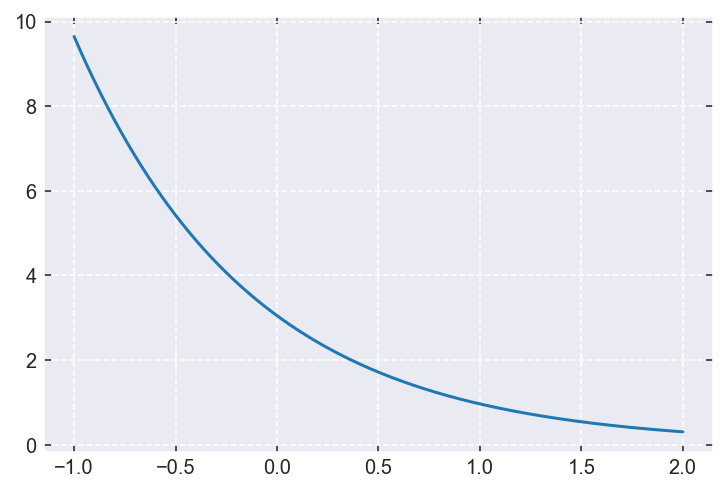

In [19]:
den=1000
a_x = 10**np.linspace(-1, 2, den)
m_x = np.linspace(0.08,0.45, 10)
m_x=0.1
v_y = critical_v(1, 0.000954, m_x, a_x)/KMS

plt.plot(np.log10(a_x), v_y)

In [20]:
aj=1*AU

sigma_unit = np.pi*aj*aj

cross = pd.DataFrame({'$m_{dwarf}[M_\odot]$': M, '$V_{inf} [km/s]$':V, '$b_{max} [au]$':B, '$N_{cap}$':Ncap, '$N_{tot}$':Ntot, '$\sigma[\pi a_{J}^2]$':np.array(SIGMA)/sigma_unit})

cross['$\Delta\sigma [\pi a_{J}^2]$'] = cross['$b_{max} [au]$']**2*np.sqrt(cross['$N_{cap}$'])/cross['$N_{tot}$']*np.pi/sigma_unit

cross['$v_{crit} [km/s]$'] = critical_v(1, 0.000954, cross['$m_{dwarf}[M_\odot]$'], 1)/KMS

In [21]:
cross

,$m_{dwarf}[M_\odot]$,$V_{inf} [km/s]$,$b_{max} [au]$,$N_{cap}$,$N_{tot}$,$\sigma[\pi a_{J}^2]$,$\Delta\sigma [\pi a_{J}^2]$,$v_{crit} [km/s]$
0,0.080,36.792980,99.9998,1,200000,0.050000,0.050000,3.380012
1,0.103,56.898811,99.9990,0,200000,0.000000,0.000000,3.010347
2,0.126,32.115300,99.9997,0,200000,0.000000,0.000000,2.749967
3,0.149,48.062598,99.9997,2,200000,0.099999,0.070710,2.554505
4,0.172,46.173060,99.9997,1,200000,0.050000,0.050000,2.401242
5,0.195,16.227959,99.9999,2,200000,0.100000,0.070711,2.277192
6,0.218,58.835409,99.9999,0,200000,0.000000,0.000000,2.174328
7,0.241,54.342096,99.9999,2,200000,0.100000,0.070711,2.087391
8,0.264,48.983540,99.9999,7,200000,0.349999,0.132287,2.012774
9,0.287,36.236900,99.9999,4,200000,0.200000,0.100000,1.947910


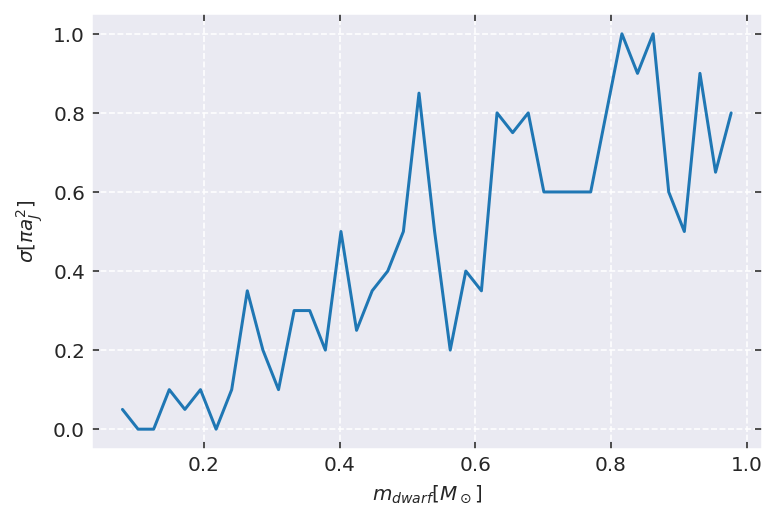

In [22]:
sns.lineplot( x='$m_{dwarf}[M_\odot]$',y='$\sigma[\pi a_{J}^2]$',err_style='band',data=cross)
#plt.errorbar(x=cross['$m_{dwarf}[M_\odot]$'], y=cross['$\sigma[\pi a_{J}^2]$'],yerr=cross['$\Delta\sigma [\pi a_{J}^2]$'])
savefig(plt,'Maxwellian-v-single-cross-section')